This notebook provides examples to go along with the [textbook](https://underactuated.csail.mit.edu/dp.html).  I recommend having both windows open, side-by-side!


In [1]:
from time import sleep

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from matplotlib import cm
from pydrake.all import (
    DiagramBuilder,
    DynamicProgrammingOptions,
    FittedValueIteration,
    LinearSystem,
    PeriodicBoundaryCondition,
    Rgba,
    Simulator,
    StartMeshcat,
    WrapToSystem,
)
from pydrake.examples import PendulumPlant

from underactuated.double_integrator import DoubleIntegratorVisualizer
from underactuated.jupyter import AdvanceToAndVisualize, running_as_notebook
from underactuated.pendulum import PendulumVisualizer

In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7002


# Value Iteration for the Double Integrator

Note that I've inserted a sleep command in the draw method to intentionally slow down the algorithm, so that you can watch the convergence in the visualizer.  If you take out the pause, it's quite fast!

In [ ]:
def DoubleIntegrator():
    return LinearSystem(
        A=np.mat("0 1; 0 0"), B=np.mat("0; 1"), C=np.eye(2), D=np.zeros((2, 1))
    )


meshcat.Delete()
meshcat.SetProperty("/Background", "visible", False)
plant = DoubleIntegrator()


def double_integrator_example(
    cost_function,
    convergence_tol,
    animate=True,
    plot=True,
    draw_iterations=True,
):
    simulator = Simulator(plant)
    options = DynamicProgrammingOptions()

    qbins = np.linspace(-3.0, 3.0, 31)
    qdotbins = np.linspace(-4.0, 4.0, 51)
    state_grid = [set(qbins), set(qdotbins)]

    input_limit = 1.0
    input_grid = [set(np.linspace(-input_limit, input_limit, 9))]
    time_step = 0.01

    [Q, Qdot] = np.meshgrid(qbins, qdotbins)

    def draw(iteration, mesh, cost_to_go, policy):
        # Don't draw every frame.
        if iteration % 20 != 0:
            return

        # TODO: color by z value (e.g. cm.jet)
        meshcat.PlotSurface(
            "Cost-to-go",
            Q,
            Qdot,
            np.reshape(cost_to_go, Q.shape),
            wireframe=True,
        )
        meshcat.PlotSurface(
            "Policy",
            Q,
            Qdot,
            np.reshape(policy, Q.shape),
            rgba=Rgba(0.3, 0.3, 0.5),
        )

        # Slow down the algorithm so we can visualize the convergence.
        sleep(0.1)

    def simulate(policy):
        # Animate the resulting policy.
        builder = DiagramBuilder()
        plant = builder.AddSystem(DoubleIntegrator())

        vi_policy = builder.AddSystem(policy)
        builder.Connect(plant.get_output_port(0), vi_policy.get_input_port(0))
        builder.Connect(vi_policy.get_output_port(0), plant.get_input_port(0))

        visualizer = builder.AddSystem(DoubleIntegratorVisualizer(show=False))
        builder.Connect(plant.get_output_port(0), visualizer.get_input_port(0))

        diagram = builder.Build()
        simulator = Simulator(diagram)

        simulator.get_mutable_context().SetContinuousState([-10.0, 0.0])

        AdvanceToAndVisualize(simulator, visualizer, 10.0)

    if running_as_notebook and draw_iterations:
        options.visualization_callback = draw
    options.convergence_tol = convergence_tol
    options.discount_factor = 1.0
    policy, cost_to_go = FittedValueIteration(
        simulator, cost_function, state_grid, input_grid, time_step, options
    )

    J = np.reshape(cost_to_go, Q.shape)

    meshcat.PlotSurface("Cost-to-go", Q, Qdot, J, wireframe=True)

    if animate:
        print("Simulating...")
        simulate(policy)

    if plot:
        fig = plt.figure(1, figsize=(9, 4))
        ax1, ax2 = fig.subplots(1, 2)
        ax1.set_xlabel("q")
        ax1.set_ylabel("qdot")
        ax1.set_title("Cost-to-Go")
        ax2.set_xlabel("q")
        ax2.set_ylabel("qdot")
        ax2.set_title("Policy")
        ax1.imshow(
            J,
            cmap=cm.jet,
            extent=(qbins[0], qbins[-1], qdotbins[-1], qdotbins[0]),
        )
        ax1.invert_yaxis()
        Pi = np.reshape(policy.get_output_values(), Q.shape)
        ax2.imshow(
            Pi,
            cmap=cm.jet,
            extent=(qbins[0], qbins[-1], qdotbins[-1], qdotbins[0]),
        )
        ax2.invert_yaxis()
        display(plt.show())

In [ ]:
def min_time_cost(context):
    x = context.get_continuous_state_vector().CopyToVector()
    if x.dot(x) < 0.05:
        return 0.0
    return 1.0


double_integrator_example(
    cost_function=min_time_cost, convergence_tol=0.001, animate=True
);

In [ ]:
def quadratic_regulator_cost(context):
    x = context.get_continuous_state_vector().CopyToVector()
    u = plant.EvalVectorInput(context, 0).CopyToVector()
    return x.dot(x) + u.dot(u)


double_integrator_example(
    cost_function=quadratic_regulator_cost, convergence_tol=0.1, animate=True
)

# Value Iteration for the Simple Pendulum

INFO:drake:Computing transition and cost matrices.
INFO:drake:Done computing transition and cost matrices.
INFO:drake:Running value iteration.
INFO:drake:Value iteration converged to requested tolerance.


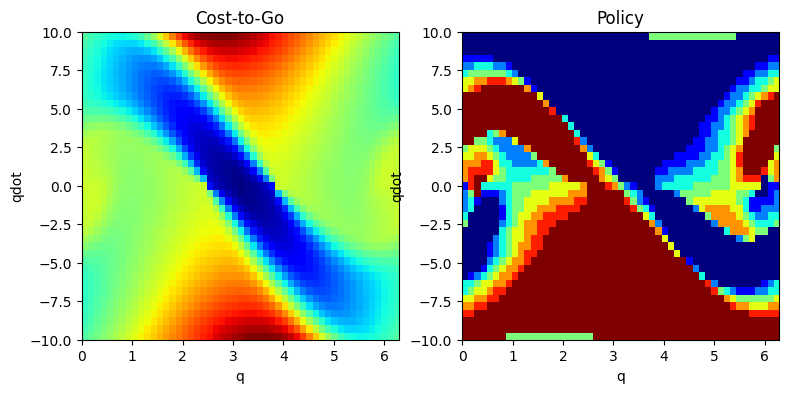

None

In [7]:
def pendulum_swingup_example(min_time=True, animate=True):
    plant = PendulumPlant()
    simulator = Simulator(plant)
    options = DynamicProgrammingOptions()

    qbins = np.linspace(0.0, 2.0 * np.pi, 51)
    qdotbins = np.linspace(-10.0, 10.0, 41)
    state_grid = [set(qbins), set(qdotbins)]
    options.periodic_boundary_conditions = [
        PeriodicBoundaryCondition(0, 0.0, 2.0 * np.pi),
    ]
    options.discount_factor = 0.999
    input_limit = 3
    input_grid = [set(np.linspace(-input_limit, input_limit, 9))]
    time_step = 0.01

    [Q, Qdot] = np.meshgrid(qbins, qdotbins)

    meshcat.Delete()
    meshcat.SetProperty("/Background", "visible", False)

    def draw(iteration, mesh, cost_to_go, policy):
        # Don't draw every frame.
        if iteration % 20 != 0:
            return

        meshcat.PlotSurface(
            "Cost-to-go",
            Q,
            Qdot,
            np.reshape(cost_to_go, Q.shape),
            wireframe=True,
        )
        meshcat.PlotSurface(
            "Policy",
            Q,
            Qdot,
            np.reshape(policy, Q.shape),
            rgba=Rgba(0.3, 0.3, 0.5),
        )

        # Slow down the algorithm so we can visualize the convergence.
        sleep(0.1)

    def simulate(policy):
        # Animate the resulting policy.
        builder = DiagramBuilder()
        pendulum = builder.AddSystem(PendulumPlant())

        wrap = builder.AddSystem(WrapToSystem(2))
        wrap.set_interval(0, 0, 2 * np.pi)
        builder.Connect(pendulum.get_output_port(0), wrap.get_input_port(0))
        vi_policy = builder.AddSystem(policy)
        builder.Connect(wrap.get_output_port(0), vi_policy.get_input_port(0))
        builder.Connect(vi_policy.get_output_port(0), pendulum.get_input_port(0))

        visualizer = builder.AddSystem(PendulumVisualizer(show=False))
        builder.Connect(pendulum.get_output_port(0), visualizer.get_input_port(0))

        diagram = builder.Build()
        simulator = Simulator(diagram)
        simulator.get_mutable_context().SetContinuousState([0.1, 0.0])

        AdvanceToAndVisualize(simulator, visualizer, 8.0)

    if running_as_notebook:
        options.visualization_callback = draw

    def min_time_cost(context):
        x = context.get_continuous_state_vector().CopyToVector()
        x[0] = x[0] - np.pi
        if x.dot(x) < 0.05:
            return 0.0
        return 1.0

    def quadratic_regulator_cost(context):
        x = context.get_continuous_state_vector().CopyToVector()
        x[0] = x[0] - np.pi
        u = plant.EvalVectorInput(context, 0).CopyToVector()
        return 2 * x.dot(x) + u.dot(u)

    if min_time:
        cost_function = min_time_cost
        options.convergence_tol = 0.001
    else:
        cost_function = quadratic_regulator_cost
        options.convergence_tol = 0.1

    policy, cost_to_go = FittedValueIteration(
        simulator, cost_function, state_grid, input_grid, time_step, options
    )

    J = np.reshape(cost_to_go, Q.shape)

    meshcat.PlotSurface("Cost-to-go", Q, Qdot, J, wireframe=True)

    if animate:
        print("Simulating...")
        simulate(policy)

    fig = plt.figure(figsize=(9, 4))
    ax1, ax2 = fig.subplots(1, 2)
    ax1.set_xlabel("q")
    ax1.set_ylabel("qdot")
    ax1.set_title("Cost-to-Go")
    ax2.set_xlabel("q")
    ax2.set_ylabel("qdot")
    ax2.set_title("Policy")
    ax1.imshow(
        Q,
        cmap=cm.jet,
        aspect="auto",
        extent=(qbins[0], qbins[-1], qdotbins[-1], qdotbins[0]),
    )
    ax1.invert_yaxis()
    Pi = np.reshape(policy.get_output_values(), Q.shape)
    ax2.imshow(
        Pi,
        cmap=cm.jet,
        aspect="auto",
        extent=(qbins[0], qbins[-1], qdotbins[-1], qdotbins[0]),
    )
    ax2.invert_yaxis()
    display(plt.show())


pendulum_swingup_example(min_time=False, animate=False)